In [1]:
import warnings
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import chisquare, expon, lognorm, norm, poisson, zipf

warnings.filterwarnings('ignore')

In [2]:
def simple_parameter_estimation(x):
    return 1 + len(x) / sum(np.log(x))

In [3]:
params = np.linspace(1.01, 2.0, 100) \
           .reshape((10, 10))

for interval in params:
    error = 0
    for s in interval:
        sample = zipf.rvs(s, size=1000)
        s_hat = simple_parameter_estimation(sample)
        error += abs(s_hat - s)
    print(f's = {(s - 0.09):.3}...{s:.2}, mean error = {error / 10}')

s = 1.01...1.1, mean error = 0.018254602158150647
s = 1.11...1.2, mean error = 0.016314789972882892
s = 1.21...1.3, mean error = 0.03553980906907037
s = 1.31...1.4, mean error = 0.07853892271321723
s = 1.41...1.5, mean error = 0.1422219191837478
s = 1.51...1.6, mean error = 0.22854643245153633
s = 1.61...1.7, mean error = 0.29867102801364764
s = 1.71...1.8, mean error = 0.40907122396519624
s = 1.81...1.9, mean error = 0.5086293710940166
s = 1.91...2.0, mean error = 0.7249177821457721


In [4]:
def chisquare_test(sample):
    s_hat = simple_parameter_estimation(sample)
    if (s_hat < 1.1):
        s_hat = 1.1
    unique, counts = np.unique(np.ceil(sample).astype(int), return_counts=True)
    counts[::-1].sort()
    return chisquare(counts, np.ceil(len(sample) * 
                                     zipf.pmf([i for i in range(1, len(counts) + 1)], s_hat)))[1]


def add_noise(sample, level, distrib, args):
    rand_values = np.random.rand(len(sample))
    for i in range(len(sample)):
        if rand_values[i] < level:
            sample[i] = distrib.rvs(*args)


tests = {'chi': chisquare_test}

In [5]:
pvalues_n = defaultdict(list)
sample_sizes = [i * 100000 for i in range(1, 10)]
s = 1.1
for n in sample_sizes:
    sample = zipf.rvs(s, size=n)
    for name in tests:
        pvalues_n[name].append(tests[name](sample))

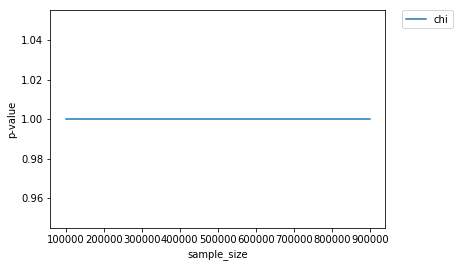

In [6]:
for name in tests:
    plt.plot(sample_sizes, pvalues_n[name], label=name)
plt.xlabel('sample_size')
plt.ylabel('p-value')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [7]:
pvalues_l = defaultdict(list)
noise_levels = [i / 100 for i in range(50)]
s = 1.1
n = 10000
for level in noise_levels:
    sample = zipf.rvs(s, size=n)
    add_noise(sample, level, lognorm, [1])
    for name in tests:
        pvalues_l[name].append(tests[name](sample))

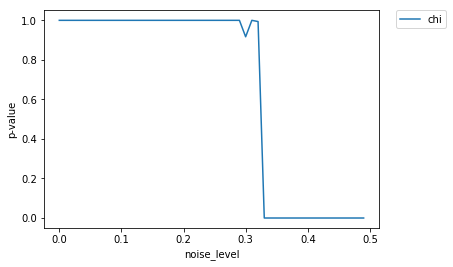

In [8]:
for name in tests:
    plt.plot(noise_levels, pvalues_l[name], label=name)
plt.xlabel('noise_level')
plt.ylabel('p-value')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [9]:
def get_false_positive(test, N=1000, s=1.1, sample_size=1000):
    false_positive = 0
    for i in range(N):
        sample = zipf.rvs(s, size=sample_size)
        if test(sample) <= 0.05:
            false_positive += 1
    return false_positive / N


def get_true_negative(test, N=1000, sample_size=1000, distrib=lognorm, args=[1]):
    true_negative = 0
    for i in range(N):
        sample = distrib.rvs(*args, size=sample_size)
        if test(sample) > 0.05:
            true_negative += 1
    return true_negative / N

In [10]:
print('false_positive')
for s in np.linspace(1.1, 2.0, num=10):
    for name in tests:
        print('s =', s)
        print(' ', name, get_false_positive(tests[name], s=s))

false_positive
s = 1.1
  chi 0.0
s = 1.2000000000000002
  chi 0.0
s = 1.3
  chi 0.0
s = 1.4000000000000001
  chi 0.0
s = 1.5
  chi 0.0
s = 1.6
  chi 0.004
s = 1.7000000000000002
  chi 0.316
s = 1.8
  chi 0.955
s = 1.9
  chi 1.0
s = 2.0
  chi 1.0


In [11]:
distribs = [('lognorm', lognorm, [10]),
            ('poisson', poisson, [1]),
            ('expon', expon, []), ]

print('true_negative')
for dist_name, dist, args in distribs:
    print(dist_name)
    for name in tests:
        print(' ', name, get_true_negative(
            tests[name], distrib=dist, args=args))

true_negative
lognorm
  chi 0.144
poisson
  chi 0.0
expon
  chi 0.0


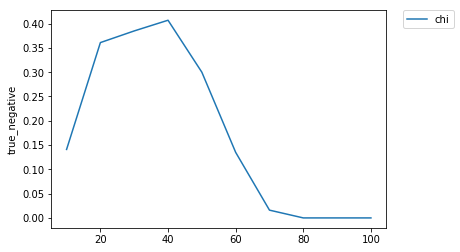

In [12]:
tn = []
for i in np.linspace(10, 100, 10):
    tn.append(get_true_negative(tests[name], distrib=lognorm, args=[i]))

for name in tests:
    plt.plot(np.linspace(10, 100, 10), tn, label=name)
plt.xlabel('')
plt.ylabel('true_negative')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()